# PPO with MLP - Features


In [2]:
import numpy as np
import yfinance as yf
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import matplotlib.dates as mdates

In [21]:
tickers = ["AAPL","MSFT","GOOGL","META","AMZN","TSLA","NVDA"]

data = {}
for t in tickers:
    df = yf.download(t, start="2023-01-01", end="2025-01-01").copy()
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    # Features and their windows are the exact same as the supervised learning 
    # EMA (5‑day)
    ema = closes.ewm(span=5, adjust=False).mean().astype(np.float32)

    # RSI (14‑day)
    delta = closes.diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = -delta.clip(upper=0).rolling(14).mean()
    rs    = gain / loss
    rsi   = (100 - 100/(1 + rs)).astype(np.float32)

    # MACD (12‑26)
    ema12 = closes.ewm(span=12, adjust=False).mean()
    ema26 = closes.ewm(span=26, adjust=False).mean()
    macd  = (ema12 - ema26).astype(np.float32)

    # Bollinger Bands (20‑day)
    mbb    = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2*mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2*mbb_sd).astype(np.float32)

    data[t] = {
        "dates":      df.index,
        "raw":        closes.values,
        "norm":       norm.values,
        "ema":        ema.values,
        "rsi":        rsi.values,
        "macd":       macd.values,
        "bb_upper":   bb_upper.values,
        "bb_lower":   bb_lower.values,
    }

raw_prices =    {t: data[t]["raw"]      for t in tickers}
normalized_prices = {t: data[t]["norm"]      for t in tickers}

# dropping any Nan values
for t in tickers:
    # stacking feature columns to detect any NaNs per row
    feat_stack = np.column_stack([
        data[t]["norm"],
        data[t]["ema"],
        data[t]["rsi"],
        data[t]["macd"],
        data[t]["bb_upper"],
        data[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)

    data[t]["dates"]    = data[t]["dates"][start_idx:]
    data[t]["raw"]      = data[t]["raw"][start_idx:]
    data[t]["norm"]     = data[t]["norm"][start_idx:]
    data[t]["ema"]      = data[t]["ema"][start_idx:]
    data[t]["rsi"]      = data[t]["rsi"][start_idx:]
    data[t]["macd"]     = data[t]["macd"][start_idx:]
    data[t]["bb_upper"] = data[t]["bb_upper"][start_idx:]
    data[t]["bb_lower"] = data[t]["bb_lower"][start_idx:]


for t in tickers:
    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data[t][feat]
        mu, sigma = arr.mean(), arr.std()
        # overwrite with z‑score normalization
        data[t][feat] = (arr - mu) / sigma

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/2472174472.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2023-01-01", end="2025-01-01").copy()
[*********************100%***********************]  1 of 1 completed
/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/2472174472.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2023-01-01", end="2025-01-01").copy()
[*********************100%***********************]  1 of 1 completed
/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/2472174472.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2023-01-01", end="2025-01-01").copy()
[*********************100%***********************]  1 of 1 completed
/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/2472174472.py:5: FutureWarning: YF.download() has c

### PPO for multiple stocks

In [60]:
state_dim   = 5  # window size 
feat_dim    = 6   # number of features per timestep
action_dim  = 1   # how many features we have 
hidden_dim  = 64  # hidden layer size 
lr          = 1e-4
gamma       = 0.9
lam         = 0.95
clip_eps    = 0.2
epochs      = 200
batch_size  = 16
l2_lambda   = 1e-4

# build multi‐stock timeseries states with 6 features per timestep
state_window = state_dim
states, next_states, rewards, dones = [], [], [], []

num_days = len(data[tickers[0]]["norm"]) - state_window - 1  # safer to get length from data dict

for day in range(num_days):
    s_day, ns_day, r_day = [], [], []
    
    for t in tickers:
        features = np.column_stack([
            data[t]["norm"],
            data[t]["ema"],
            data[t]["rsi"],
            data[t]["macd"],
            data[t]["bb_upper"],
            data[t]["bb_lower"],
        ])
        
        s_feat = features[day:day+state_window]            # shape: (window, 6)
        ns_feat = features[day+1:day+1+state_window]        # shape: (window, 6)
        reward = (data[t]["norm"][day+state_window+1] - data[t]["norm"][day+state_window]).item()

        s_day.append(s_feat)
        ns_day.append(ns_feat)
        r_day.append(reward)
        
    states.append(s_day)
    next_states.append(ns_day)
    rewards.append(r_day)
    dones.append([0.0] * len(tickers))

# convert to tensors 
states      = torch.tensor(np.array(states),      dtype=torch.float32)
next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
rewards     = torch.tensor(np.array(rewards),     dtype=torch.float32)
dones       = torch.tensor(np.array(dones),       dtype=torch.float32)

# Neural Network 
# initialising weights 
w1      = torch.nn.Parameter(torch.randn(state_dim * feat_dim, hidden_dim) * 0.1, requires_grad=True)
w2a     = torch.nn.Parameter(torch.randn(hidden_dim, action_dim) * 0.1, requires_grad=True)
w2c     = torch.nn.Parameter(torch.randn(hidden_dim, 1)          * 0.1, requires_grad=True)
log_std = torch.nn.Parameter(torch.zeros(action_dim))

# L2 & optimizer
optimizer = torch.optim.Adam([
    {'params': [w1, w2a, w2c], 'weight_decay': l2_lambda},
    {'params': [log_std],       'weight_decay': 0.0},], lr=lr)

# MLP forward
def mlp_forward(x, w1, w2):
    h = F.relu(x @ w1)
    return h @ w2

# Sample actions
# UPDATED: inputs w1, w2a, log_std so they can be accessed by the environment 
def get_action(state, w1, w2a, log_std):
    mean     = mlp_forward(state, w1, w2a)
    std      = log_std.exp()
    dist     = torch.distributions.Normal(mean, std)
    action   = dist.sample()
    log_prob = dist.log_prob(action).sum(axis=-1)
    return action, log_prob

actor_loss_hist = []
logprob_hist = []

# Collect trajectories (days × stocks) 
with torch.no_grad():
    all_actions   = []
    all_log_probs = []
    all_values    = []

    for day in range(len(states)):            # 1) loop over days
        for stock in range(states.size(1)):  # 2) inner loop over 5 stocks
            s = states[day, stock].view(1, -1)
            a, lp = get_action(s, w1, w2a, log_std)
            v     = mlp_forward(s, w1, w2c)

            all_actions  .append(a)
            all_log_probs.append(lp)
            all_values   .append(v)

    # bootstrap final values for each stock
    for stock in range(next_states.size(1)):
        s_final = next_states[-1, stock].view(1, -1)
        all_values.append(mlp_forward(s_final, w1, w2c))

# reshape into tensors
actions   = torch.cat(all_actions).view(len(states), -1, action_dim)
log_probs = torch.stack(all_log_probs).view(len(states), -1)
values    = torch.stack(all_values).view(len(states)+1, states.size(1))

# GAE calculation
advantages = torch.zeros_like(rewards)
for stock in range(states.size(1)):
    last_adv = 0
    for t in reversed(range(len(states))):
        delta    = rewards[t,stock] \
                   + gamma * values[t+1,stock] * (1 - dones[t,stock]) \
                   - values[t,stock]
        last_adv = delta + gamma * lam * (1 - dones[t,stock]) * last_adv
        advantages[t,stock] = last_adv
returns = advantages + values[:-1]

# flatten transitions for PPO
flat_states = states.view(-1, state_dim * feat_dim)
flat_actions = actions.view(-1, action_dim)
flat_lp_old  = log_probs.view(-1)
flat_ret     = returns.view(-1)
flat_adv     = advantages.view(-1)

critic_loss_hist = []
reward_hist = []
entropy_hist = []

# compute number of mini‑batches per epoch
n_trans   = flat_states.size(0)

n_batches = math.ceil(n_trans / batch_size)

# PPO training
for epoch in range(epochs):
    perm = torch.randperm(n_trans)
    epoch_actor_loss  = 0.0
    epoch_critic_loss = 0.0
    epoch_reward      = 0.0
    epoch_entropy     = 0.0
    epoch_logprob     = 0.0
    for batch_idx, start in enumerate(range(0, n_trans, batch_size), start=1):
        idx          = perm[start:start+batch_size]
        state_batch  = flat_states[idx]
        action_batch = flat_actions[idx].unsqueeze(1)
        old_logps_b  = flat_lp_old[idx].detach()
        return_batch = flat_ret[idx].detach()
        adv_batch    = flat_adv[idx].detach()

        # actor
        mean     = mlp_forward(state_batch, w1, w2a)
        std      = log_std.exp()
        dist     = torch.distributions.Normal(mean, std)
        new_lps  = dist.log_prob(action_batch).sum(axis=-1)

        ratio    = (new_lps - old_logps_b).exp()
        clipped  = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
        actor_loss = -torch.min(ratio * adv_batch, clipped).mean()

        # record entropy & log‐prob stats for this batch
        batch_entropy = dist.entropy().sum(axis=-1).mean()       # average entropy over batch
        batch_logprob = new_lps.mean()                          # average log‐prob over batch
        epoch_entropy += batch_entropy.item()
        epoch_logprob += batch_logprob.item()

        # critic
        value_pred  = mlp_forward(state_batch, w1, w2c).squeeze(-1)
        critic_loss = F.mse_loss(value_pred, return_batch)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_actor_loss  += actor_loss.item()
        epoch_critic_loss += critic_loss.item()
        epoch_reward      += return_batch.mean().item()

        # per‑batch print
        print(f"  Epoch {epoch+1}, Batch {batch_idx}/{n_batches} → Batch Loss: {loss.item():.4f}")

    actor_loss_hist .append(epoch_actor_loss  / n_batches)
    critic_loss_hist.append(epoch_critic_loss / n_batches)
    reward_hist     .append(epoch_reward      / n_batches)
    entropy_hist    .append(epoch_entropy     / n_batches)
    logprob_hist    .append(epoch_logprob     / n_batches)


  Epoch 1, Batch 1/209 → Batch Loss: 0.0298
  Epoch 1, Batch 2/209 → Batch Loss: 0.1777
  Epoch 1, Batch 3/209 → Batch Loss: -0.0396
  Epoch 1, Batch 4/209 → Batch Loss: 0.0704
  Epoch 1, Batch 5/209 → Batch Loss: -0.0104
  Epoch 1, Batch 6/209 → Batch Loss: 0.0657
  Epoch 1, Batch 7/209 → Batch Loss: 0.2373
  Epoch 1, Batch 8/209 → Batch Loss: 0.0324
  Epoch 1, Batch 9/209 → Batch Loss: 0.0516
  Epoch 1, Batch 10/209 → Batch Loss: -0.0016
  Epoch 1, Batch 11/209 → Batch Loss: 0.1250
  Epoch 1, Batch 12/209 → Batch Loss: 0.0265
  Epoch 1, Batch 13/209 → Batch Loss: -0.0207
  Epoch 1, Batch 14/209 → Batch Loss: 0.0558
  Epoch 1, Batch 15/209 → Batch Loss: 0.8908
  Epoch 1, Batch 16/209 → Batch Loss: 0.1389
  Epoch 1, Batch 17/209 → Batch Loss: 0.0523
  Epoch 1, Batch 18/209 → Batch Loss: -0.0384
  Epoch 1, Batch 19/209 → Batch Loss: -0.0658
  Epoch 1, Batch 20/209 → Batch Loss: -0.0610
  Epoch 1, Batch 21/209 → Batch Loss: -0.0000
  Epoch 1, Batch 22/209 → Batch Loss: -0.0173
  Epoch 1,

In [62]:

torch.save({
    'w1': w1,
    'w2a': w2a,
    'w2c': w2c,
    'log_std': log_std
}, 'MLP_Feat_1.pth')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/miagauci/Documents/FYP_PPO/PyTorch/MLP_Features/MLP_Features/actor_loss_and_logprob5.png'

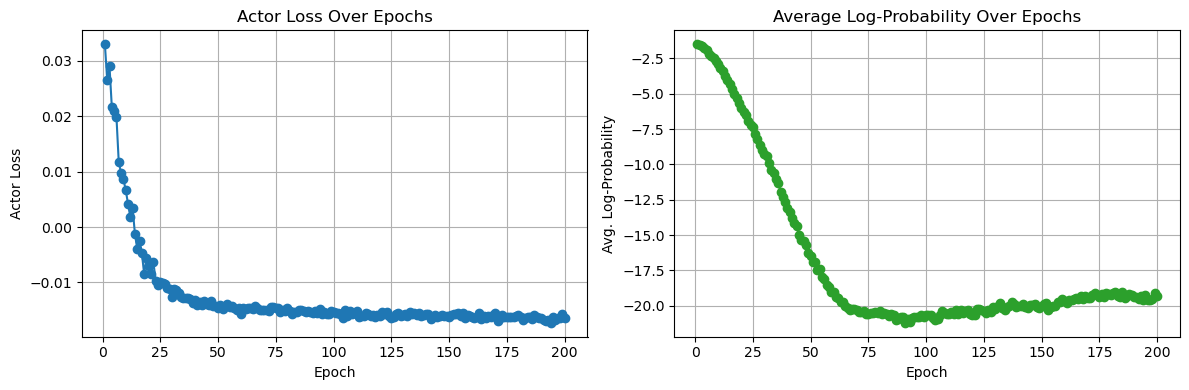

In [64]:
# Plot results after training
epochs_range = list(range(1, len(actor_loss_hist)+1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# 5.3.1 Actor Loss Over Epochs
ax1.plot(epochs_range, actor_loss_hist, marker='o')
ax1.set_title("Actor Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Actor Loss")
ax1.grid(True)

# 5.3.3 Log-Probability of Actions
ax2.plot(epochs_range, logprob_hist, marker='o', color='tab:green')
ax2.set_title("Average Log-Probability Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg. Log-Probability")
ax2.grid(True)

plt.tight_layout()
plt.savefig("MLP_Features/actor_loss_and_logprob5.png", dpi=300)
plt.show()


### Trading Environment 

In [66]:
class MultiStockEnvironment:
    def __init__(self, data, window_size, initial_cash=10000):
        self.data = data  # this is now the full data dict with all features
        self.window_size  = window_size
        self.initial_cash = float(initial_cash)
        self.tickers      = list(data.keys())
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.initial_cash
        self.holdings = {t: 0.0 for t in self.tickers}
        self.portfolio_values = [self.initial_cash]
        self.done = False

        return {
            t: np.column_stack([
                self.data[t]["norm"][0:self.window_size],
                self.data[t]["ema"][0:self.window_size],
                self.data[t]["rsi"][0:self.window_size],
                self.data[t]["macd"][0:self.window_size],
                self.data[t]["bb_upper"][0:self.window_size],
                self.data[t]["bb_lower"][0:self.window_size],
            ])
            for t in self.tickers
        }

    def step(self, actions):
        # Liquidate negatives
        freed_cash = 0.0
        for t in self.tickers:
            if actions[t] < 0 and self.holdings[t] > 0:
                price = self.data[t]["raw"][self.t + self.window_size].item()
                freed_cash += self.holdings[t] * price
                self.holdings[t] = 0.0
        self.cash += freed_cash

        # Allocate positives
        pos_actions = {t: actions[t] for t in self.tickers if actions[t] > 0}
        total_pos   = sum(pos_actions.values())
        if total_pos > 0 and self.cash > 0:
            for t, a in pos_actions.items():
                weight = a / total_pos
                price = self.data[t]["raw"][self.t + self.window_size].item()
                buy_amount = self.cash * weight
                self.holdings[t] += buy_amount / price
            self.cash = 0.0

        # Compute portfolio value
        pv = self.cash
        for t in self.tickers:
            price = self.data[t]["raw"][self.t + self.window_size].item()
            pv += self.holdings[t] * price
        self.portfolio_values.append(pv)

        # Advance time
        self.t += 1
        if self.t + self.window_size >= len(self.data[self.tickers[0]]["raw"]):
            self.done = True

        # Next state
        next_states = None
        if not self.done:
            next_states = {
                t: np.column_stack([
                    self.data[t]["norm"][self.t : self.t + self.window_size],
                    self.data[t]["ema"][self.t : self.t + self.window_size],
                    self.data[t]["rsi"][self.t : self.t + self.window_size],
                    self.data[t]["macd"][self.t : self.t + self.window_size],
                    self.data[t]["bb_upper"][self.t : self.t + self.window_size],
                    self.data[t]["bb_lower"][self.t : self.t + self.window_size],
                ])
                for t in self.tickers
            }

        return next_states, pv, self.done, {}


### buy and hold

In [69]:
class BuyAndHoldEnvironment:
    def __init__(self, raw_prices, initial_cash=10000):
        self.raw_prices = raw_prices
        self.initial_cash = initial_cash
        self.portfolio_values = []

    def run(self, start_index=30):
        # stack into shape (T,5)
        prices = np.stack([self.raw_prices[t] for t in tickers], axis=1)
        # equal allocation
        alloc = self.initial_cash / len(tickers)
        init_p = prices[start_index]            
        shares = alloc / init_p                 
        # build PV curve
        for p in prices[start_index+1:]:
            self.portfolio_values.append((shares * p).sum())

### Simulate Agent with the trained MLP once 

In [72]:
# Precompute price normalization stats (still needed for logging only)
mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price  = {t: raw_prices[t].std()  for t in tickers}

# Instantiate the environment with full data (not just raw_prices)
env = MultiStockEnvironment(data, window_size=state_dim)
state_dict = env.reset()

day = 0
print("Starting multi-stock simulation...\n")

while not env.done:
    # Sample actions from current state
    actions = {}
    trades  = {}
    for t in tickers:
        win = state_dict[t]  # shape: (state_dim, 6)

        # Already normalized in data — just flatten
        st = torch.tensor(win, dtype=torch.float32).view(1, -1)  # shape: (1, 30)

        a_tensor, _ = get_action(st, w1, w2a, log_std)
        a_val       = a_tensor.item()
        actions[t]  = a_val

        if   a_val > 0 and env.holdings[t] == 0:
            trades[t] = "BUY"
        elif a_val < 0 and env.holdings[t] > 0:
            trades[t] = "SELL"
        else:
            trades[t] = "HOLD"

    # Step the environment
    next_states, port_val, done, _ = env.step(actions)

    # Log values
    cash = float(env.cash)
    prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}
    held   = {t: float(env.holdings[t]) for t in tickers}

    # Print summary and per-ticker details
    print(f"Day {day}: Cash = {cash:.2f}, Portfolio = {port_val:.2f}")
    for t in tickers:
        print(f"  {t:>6s} | Price = {prices[t]:6.2f} | "
              f"Action = {actions[t]:6.4f} | Trade = {trades[t]:>4s} | "
              f"Held = {held[t]:6.4f}")
    print("-" * 60)

    # advance
    state_dict = next_states
    day += 1

print(f"\nDone. Final portfolio value: {env.portfolio_values[-1]:.2f}")


Starting multi-stock simulation...

Day 0: Cash = 0.00, Portfolio = 10000.00
    AAPL | Price = 129.06 | Action = 19.5738 | Trade =  BUY | Held = 11.0067
    MSFT | Price = 224.29 | Action = 18.9321 | Trade =  BUY | Held = 6.1981
   GOOGL | Price =  87.89 | Action = 16.3451 | Trade =  BUY | Held = 13.1146
    META | Price = 132.26 | Action = 18.3724 | Trade =  BUY | Held = 8.2765
    AMZN | Price =  89.87 | Action = 12.6975 | Trade =  BUY | Held = 10.6756
    TSLA | Price = 118.85 | Action = 16.8777 | Trade =  BUY | Held = 7.3623
    NVDA | Price =  15.89 | Action = 13.6827 | Trade =  BUY | Held = 53.0246
------------------------------------------------------------
Day 1: Cash = 0.00, Portfolio = 9802.76
    AAPL | Price = 131.78 | Action = 19.0865 | Trade = HOLD | Held = 11.0067
    MSFT | Price = 231.07 | Action = 19.3488 | Trade = HOLD | Held = 6.1981
   GOOGL | Price =  90.97 | Action = 16.0086 | Trade = HOLD | Held = 13.1146
    META | Price = 132.16 | Action = 19.0019 | Trade = H

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/1593004457.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}


Day 98: Cash = 0.00, Portfolio = 13405.38
    AAPL | Price = 178.30 | Action = 4.3462 | Trade = HOLD | Held = 11.0067
    MSFT | Price = 327.49 | Action = 5.6471 | Trade = HOLD | Held = 6.1981
   GOOGL | Price = 122.98 | Action = 4.6601 | Trade = HOLD | Held = 13.1146
    META | Price = 271.12 | Action = 8.5064 | Trade = HOLD | Held = 8.2765
    AMZN | Price = 122.77 | Action = 8.8415 | Trade = HOLD | Held = 10.6756
    TSLA | Price = 207.52 | Action = 3.7908 | Trade = HOLD | Held = 7.3623
    NVDA | Price =  39.74 | Action = 7.6443 | Trade = HOLD | Held = 53.0246
------------------------------------------------------------
Day 99: Cash = 0.00, Portfolio = 13675.42
    AAPL | Price = 179.16 | Action = 4.9379 | Trade = HOLD | Held = 11.0067
    MSFT | Price = 330.26 | Action = 4.4474 | Trade = HOLD | Held = 6.1981
   GOOGL | Price = 123.93 | Action = 5.5996 | Trade = HOLD | Held = 13.1146
    META | Price = 271.12 | Action = 6.9107 | Trade = HOLD | Held = 8.2765
    AMZN | Price = 124.2


Final Results:
PPO final portfolio:       46327.42
Buy & Hold final portfolio:35231.80


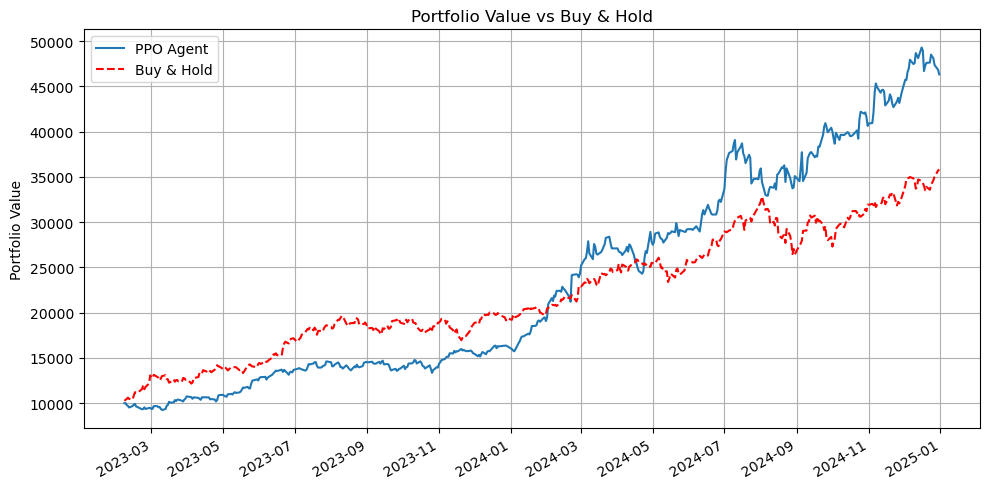

In [74]:
bh_env = BuyAndHoldEnvironment(raw_prices)
bh_env.run(start_index=state_dim)

# 3) Final values
print("\nFinal Results:")
print(f"PPO final portfolio:       {env.portfolio_values[-1]:.2f}")
print(f"Buy & Hold final portfolio:{bh_env.portfolio_values[-1]:.2f}")


# 1) Convert dates to datetime explicitly
dates = pd.to_datetime(data[tickers[0]]["dates"])  # ensure it's datetime

# 2) Align the PPO curve to start after `state_dim`
ppo_curve = env.portfolio_values
L_ppo = len(ppo_curve)
ppo_dates = dates[state_dim - 1 : state_dim - 1 + L_ppo]

# 3) Buy & Hold
bh = BuyAndHoldEnvironment(raw_prices)
bh.run(start_index=state_dim)
bh_curve = bh.portfolio_values
L_bh = len(bh_curve)
bh_dates = dates[state_dim - 1 : state_dim - 1 + L_bh]

# 4) Truncate both to the shortest length
min_len = min(len(ppo_dates), len(bh_dates), len(ppo_curve), len(bh_curve))

ppo_dates = ppo_dates[:min_len]
ppo_curve = ppo_curve[:min_len]
bh_dates  = bh_dates[:min_len]
bh_curve  = bh_curve[:min_len]

# 5) Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ppo_dates, ppo_curve, label="PPO Agent")
ax.plot(bh_dates, bh_curve, 'r--', label="Buy & Hold")

ax.set_title("Portfolio Value vs Buy & Hold")
ax.set_ylabel("Portfolio Value")
ax.legend()
ax.grid(True)

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig("MLP_CP_DATES_6.png", dpi=600)
plt.show()


### Run the Environment 50 times to get an average on how the MLP is performing

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/977285639.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("MLP_Feat_1.pth")


Run  1/20 → Final Portfolio Value: 34674.52
Run  2/20 → Final Portfolio Value: 41894.22
Run  3/20 → Final Portfolio Value: 44973.24
Run  4/20 → Final Portfolio Value: 32106.00
Run  5/20 → Final Portfolio Value: 39630.27
Run  6/20 → Final Portfolio Value: 51769.60
Run  7/20 → Final Portfolio Value: 54103.35
Run  8/20 → Final Portfolio Value: 45971.49
Run  9/20 → Final Portfolio Value: 40203.69
Run 10/20 → Final Portfolio Value: 46398.59
Run 11/20 → Final Portfolio Value: 46918.35
Run 12/20 → Final Portfolio Value: 39955.55
Run 13/20 → Final Portfolio Value: 39831.98
Run 14/20 → Final Portfolio Value: 37490.11
Run 15/20 → Final Portfolio Value: 48399.15
Run 16/20 → Final Portfolio Value: 44854.74
Run 17/20 → Final Portfolio Value: 53843.17
Run 18/20 → Final Portfolio Value: 51168.07
Run 19/20 → Final Portfolio Value: 59194.97
Run 20/20 → Final Portfolio Value: 39134.48

Summary over 20 runs:
→ Mean Final Portfolio: 44625.78 ± 6852.41
→ Min: 32106.00, Max: 59194.97
→ Buy & Hold Final Port

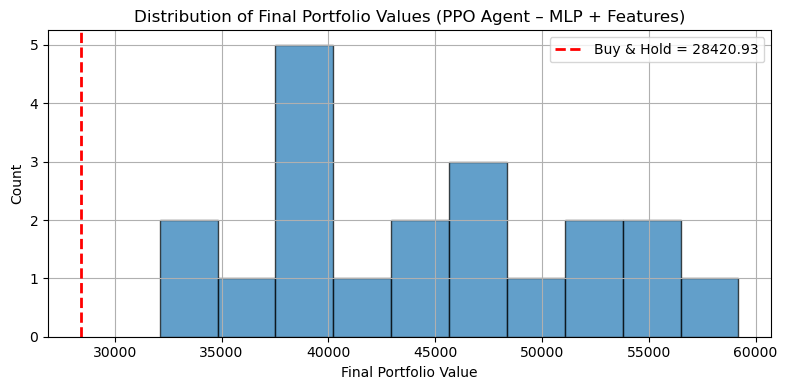

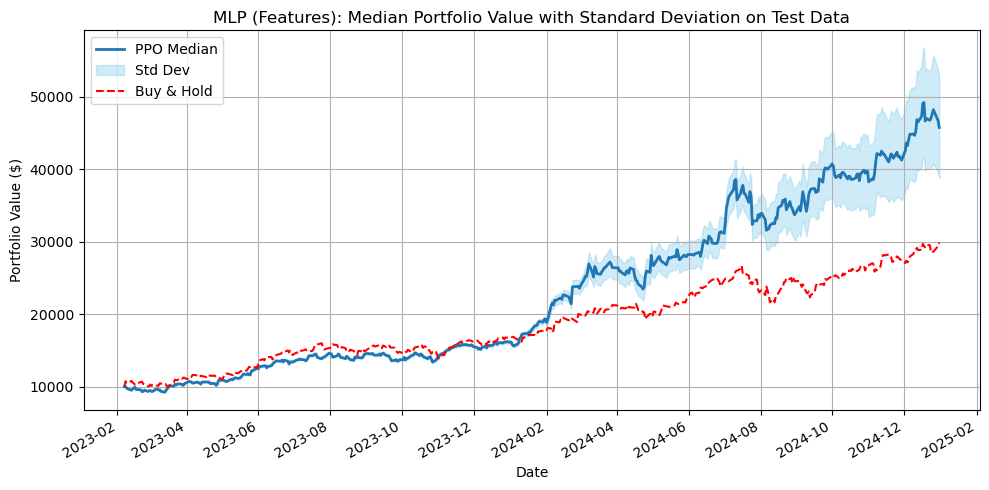

In [76]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import torch.nn.functional as F
import os

# === Setup ===
tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
state_dim = 5
feat_dim = 6
action_dim = 1
n_runs = 20

w1 = torch.nn.Parameter(torch.empty(state_dim * feat_dim, 64))
w2a = torch.nn.Parameter(torch.empty(64, action_dim))
log_std = torch.nn.Parameter(torch.empty(action_dim))


state_dict = torch.load("MLP_Feat_1.pth")
w1.data.copy_(state_dict['w1'])
w2a.data.copy_(state_dict['w2a'])
log_std.data.copy_(state_dict['log_std'])

# === Load Buy & Hold data ===
with open("buyhold_2023_2025.pkl", "rb") as f:
    bh_data = pickle.load(f)
buy_hold_curve = bh_data["curve"]
buy_hold_value = buy_hold_curve[-1]
bh_dates = pd.to_datetime(bh_data["dates"])

# === Run PPO agent ===
final_portfolios = []
ppo_trajectories = []

for run in range(n_runs):
    env = MultiStockEnvironment(data, window_size=state_dim)
    state_dict = env.reset()
    done = False

    while not done:
        actions = {}
        for t in tickers:
            win = state_dict[t]              # shape: (5, 6)
            flat_win = win.flatten()         # shape: (30,)
            st = torch.tensor(flat_win, dtype=torch.float32).view(1, -1)
            with torch.no_grad():
                a_tensor, _ = get_action(st, w1, w2a, log_std)
            actions[t] = a_tensor.item()

        state_dict, _, done, _ = env.step(actions)

    final_value = env.portfolio_values[-1]
    final_portfolios.append(final_value)
    ppo_trajectories.append(env.portfolio_values)
    print(f"Run {run+1:2d}/{n_runs} → Final Portfolio Value: {final_value:.2f}")

# === Summary ===
mean_pf = np.mean(final_portfolios)
std_pf = np.std(final_portfolios)
min_pf = np.min(final_portfolios)
max_pf = np.max(final_portfolios)
beats_bh = sum(p > buy_hold_value for p in final_portfolios)
beat_pct = beats_bh / n_runs * 100

print(f"\nSummary over {n_runs} runs:")
print(f"→ Mean Final Portfolio: {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Buy & Hold Final Portfolio: {buy_hold_value:.2f}")
print(f"→ PPO Agent beat Buy & Hold in {beat_pct:.1f}% of runs ({beats_bh}/{n_runs})")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_portfolios, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(buy_hold_value, color='r', linestyle='--', linewidth=2,
            label=f'Buy & Hold = {buy_hold_value:.2f}')
plt.title("Distribution of Final Portfolio Values (PPO Agent – MLP + Features)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Trajectory plot ===
ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve = np.std(ppo_array, axis=0)

x_dates = bh_dates[state_dim - 1:state_dim - 1 + len(median_curve)]
min_len = min(len(x_dates), len(median_curve), len(buy_hold_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
buy_hold_curve = buy_hold_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, buy_hold_curve, 'r--', label='Buy & Hold')

plt.title("MLP (Features): Median Portfolio Value with Standard Deviation on Test Data")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


### test on unseen data 

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3908/2166793672.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("MLP_Feat_1.pth")
/va

Running PPO (MLP + Features) on Test Data...

Run   1/200 → Final Value: 11962.62
Run   2/200 → Final Value: 11021.10
Run   3/200 → Final Value: 11095.89
Run   4/200 → Final Value: 11888.60
Run   5/200 → Final Value: 11397.64
Run   6/200 → Final Value: 11415.36
Run   7/200 → Final Value: 12468.57
Run   8/200 → Final Value: 11293.90
Run   9/200 → Final Value: 11340.16
Run  10/200 → Final Value: 10287.60
Run  11/200 → Final Value: 12695.15
Run  12/200 → Final Value: 11666.22
Run  13/200 → Final Value: 11923.79
Run  14/200 → Final Value: 10331.30
Run  15/200 → Final Value: 11140.01
Run  16/200 → Final Value: 11820.31
Run  17/200 → Final Value: 11114.00
Run  18/200 → Final Value: 10142.69
Run  19/200 → Final Value: 10501.04
Run  20/200 → Final Value: 11036.43
Run  21/200 → Final Value: 11569.09
Run  22/200 → Final Value: 10405.14
Run  23/200 → Final Value: 10495.33
Run  24/200 → Final Value: 11460.67
Run  25/200 → Final Value: 12045.56
Run  26/200 → Final Value: 10484.09
Run  27/200 → Fina

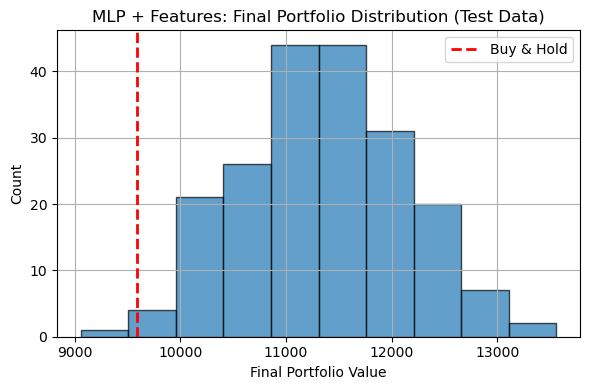

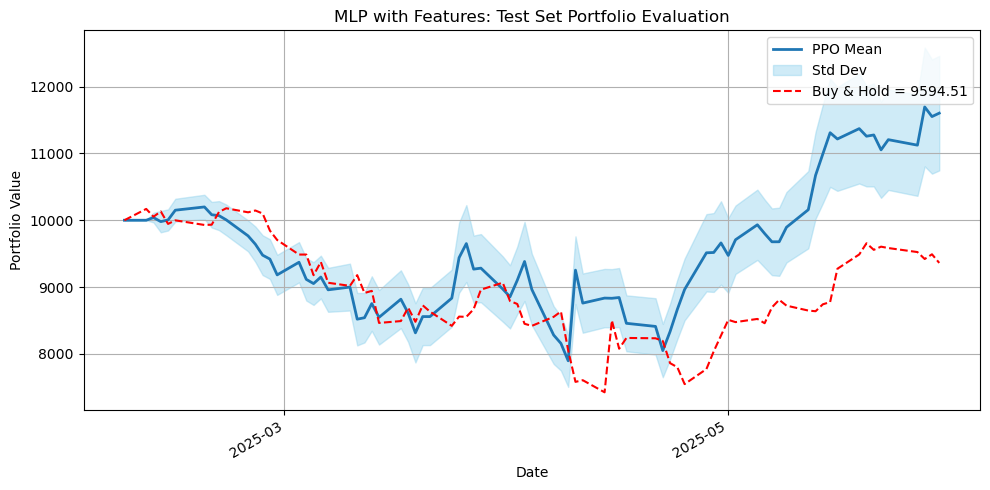

In [82]:
import yfinance as yf
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pickle

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
start, end = "2025-01-01", "2025-06-01"
initial_cash = 10000.0
state_dim = 5
n_runs = 200

w1 = torch.nn.Parameter(torch.empty(state_dim * feat_dim, hidden_dim))  # [30, 64]
w2a = torch.nn.Parameter(torch.empty(hidden_dim, action_dim))           # [64, 1]
log_std = torch.nn.Parameter(torch.zeros(action_dim))                   # [1]

# Load saved weights
state_dict = torch.load("MLP_Feat_1.pth")
w1.data.copy_(state_dict["w1"])
w2a.data.copy_(state_dict["w2a"])
log_std.data.copy_(state_dict["log_std"])

# === Load test Buy & Hold curve ===
with open("buyhold_2025_2025.pkl", "rb") as f:
    bh_data = pickle.load(f)
buy_hold_curve = bh_data["curve"]
bh_final = buy_hold_curve[-1]
bh_dates = pd.to_datetime(bh_data["dates"])

# === Prepare test data with full features ===
data_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end)
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    ema = closes.ewm(span=5).mean().astype(np.float32)
    delta = closes.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    rsi = (100 - 100 / (1 + rs)).astype(np.float32)
    ema12 = closes.ewm(span=12).mean()
    ema26 = closes.ewm(span=26).mean()
    macd = (ema12 - ema26).astype(np.float32)
    mbb = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2 * mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2 * mbb_sd).astype(np.float32)

    data_test[t] = {
        "dates": df.index,
        "raw": closes.values,
        "norm": norm.values,
        "ema": ema.values,
        "rsi": rsi.values,
        "macd": macd.values,
        "bb_upper": bb_upper.values,
        "bb_lower": bb_lower.values,
    }

# Drop NaNs
for t in tickers:
    feat_stack = np.column_stack([
        data_test[t]["norm"],
        data_test[t]["ema"],
        data_test[t]["rsi"],
        data_test[t]["macd"],
        data_test[t]["bb_upper"],
        data_test[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)
    for key in data_test[t]:
        data_test[t][key] = data_test[t][key][start_idx:]

# Normalize features
for t in tickers:
    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data_test[t][feat]
        mu, sigma = arr.mean(), arr.std()
        data_test[t][feat] = (arr - mu) / sigma

# === PPO Evaluation ===
final_pf = []
ppo_trajectories = []

print("Running PPO (MLP + Features) on Test Data...\n")

for run in range(n_runs):
    env = MultiStockEnvironment(data_test, window_size=state_dim)
    state_dict = env.reset()
    done = False
    trajectory = [env.initial_cash]

    while not done:
        actions = {}
        for t in tickers:
            win = state_dict[t]
            flat = win.flatten()
            st = torch.tensor(flat, dtype=torch.float32).view(1, -1)
            a = get_action(st, w1, w2a, log_std)[0].item()
            actions[t] = a

        state_dict, pv, done, _ = env.step(actions)
        trajectory.append(pv)

    final_val = trajectory[-1]
    final_pf.append(final_val)
    ppo_trajectories.append(trajectory)
    print(f"Run {run+1:3d}/{n_runs} → Final Value: {final_val:.2f}")

# === Pad PPO trajectories and align Buy & Hold ===
max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last] * (max_len - len(ppo_trajectories[i]))

ppo_array = np.array(ppo_trajectories)
mean_curve = np.mean(ppo_array, axis=0)
std_curve  = np.std(ppo_array, axis=0)

# === Summary ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
beats = sum(p > bh_final for p in final_pf)
bh_return = (bh_final / initial_cash - 1) * 100

print(f"\n=== PPO on Unseen Data (MLP + Features) ===")
print(f"Runs: {n_runs}")
print(f"→ Final Portfolio: mean {mean_pf:.2f} ±{std_pf:.2f}")
print(f"→ Min: {np.min(final_pf):.2f}, Max: {np.max(final_pf):.2f}")
print(f"→ Buy & Hold Final Portfolio: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beats/n_runs*100:.1f}%)")

def annualized_return(final, initial, years=1):
    return ((final / initial) ** (1 / years) - 1) * 100

print(f"→ PPO Annualized Return: {annualized_return(mean_pf, initial_cash):.2f}%")
print(f"→ Buy & Hold Return:      {annualized_return(bh_final, initial_cash):.2f}%")

# === Histogram ===
plt.figure(figsize=(6, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label='Buy & Hold')
plt.title("MLP + Features: Final Portfolio Distribution (Test Data)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("MLP_Features/UNSEEN_hist.png", dpi=600)
plt.show()

# === Median ± Std Dev plot ===
x_dates = bh_dates[state_dim - 1 : state_dim - 1 + max_len]
min_len = min(len(x_dates), len(mean_curve), len(buy_hold_curve))
x_dates = x_dates[:min_len]
mean_curve = mean_curve[:min_len]
std_curve = std_curve[:min_len]
buy_hold_curve = buy_hold_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, mean_curve, label="PPO Mean", linewidth=2)
plt.fill_between(x_dates, mean_curve - std_curve, mean_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, buy_hold_curve, 'r--', label=f'Buy & Hold = {bh_final:.2f}')
plt.title("MLP with Features: Test Set Portfolio Evaluation")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
